In [25]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import seaborn as sns
import umap
import random
from dataclasses import dataclass
import numpy as np
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
import umap.plot
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from lib.eval.generator import run, returnNames
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mnist general experiments

In [26]:
cf_amount = 1
nc = 10
random_state = 42

digits, target = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
#digits = datasets.load_digits()
#print(digits.images.shape)
#n_samples = len(digits.images)
X = digits.astype(np.float64)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

def showim(x, ax = None):
    p = plt if ax is None else ax
    p.imshow(x[0].reshape(28, 28))
    if ax is None:
        plt.show()

# Reversible

/home/kvist/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kvist/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/kvist/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


38447


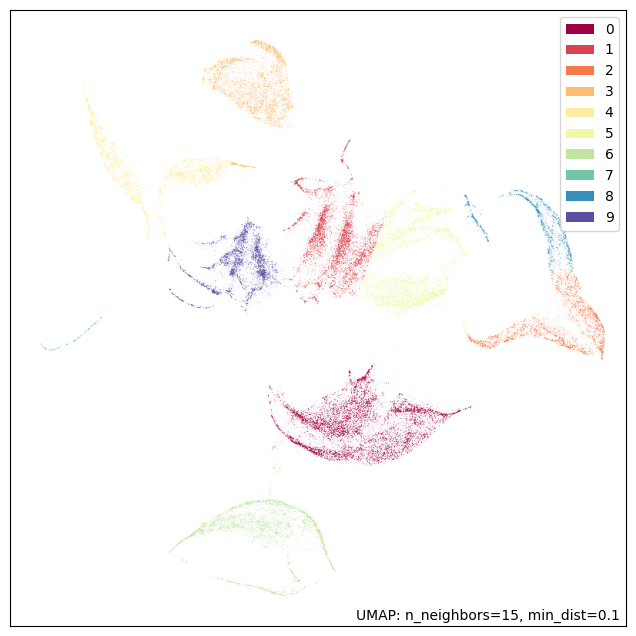

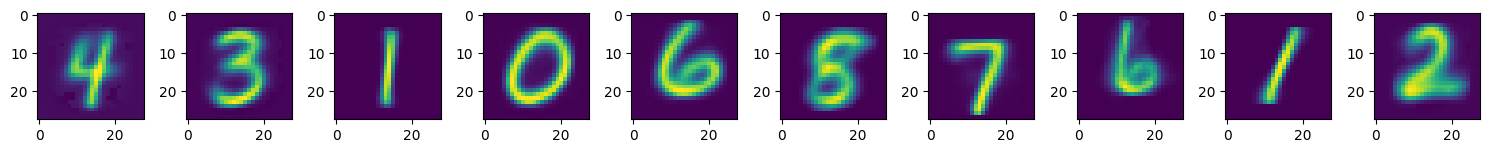

In [27]:
reducer = umap.UMAP(random_state=random_state)
mapper = reducer.fit(X)
transformed_data = reducer.transform(X)

km = KMeans(n_clusters=nc,random_state=random_state)
y = km.fit_predict(transformed_data)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float

cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(transformed_data)-1)
    print(index)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

umap.plot.points(mapper,labels=y)

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, c in enumerate(scaler.inverse_transform(mapper.inverse_transform(centers))):
    showim(c.reshape(1, -1), ax=axes[i])
plt.tight_layout()
plt.show()

In [32]:
umap_cfs = []
method_name = "dice_mod"

match method_name:
    case "cfae":
        amount = 10
        print('starting cfae')
        for cf in cfs:
            temp_cfs = []
            for i in range(amount):
                print('it: ' + str(i))
                x2, cf2, h2 = CF_Ascent(X=transformed_data,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=80, center_mode=False)
                temp_cfs.append(cf2)
        umap_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))
    case "dice_mod":
        for cf in cfs:
            instance = transformed_data[cf.instance].reshape(1, -1)
            gainer = Gainer(centers, transformed_data, cf.target, instance, eps=0)
            dice_cf = np.array([
                # random_opt(instance, gainer.gain)[0][0] 
                adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]
            for _ in range(1)])
            umap_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

X: (70000, 2)
C: (10, 2)
x: (1, 2)
iter: 127, score: 0.7402819395065308


Instance


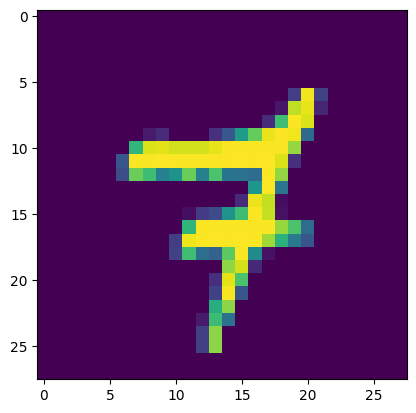

target


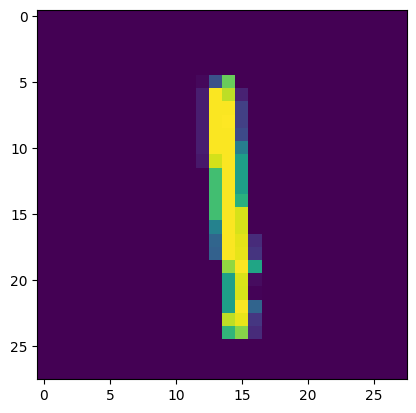

counterfactuals:


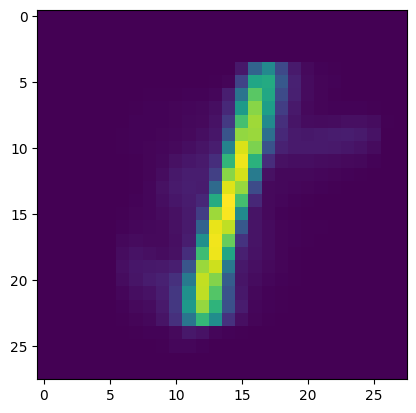

In [33]:
index = umap_cfs[0].instance

print("Instance")
sample = scaler.inverse_transform([X[index]])
showim([sample])

print("target")
target = scaler.inverse_transform([X[umap_cfs[0].target]])
showim([target])

print("counterfactuals:")
u_cfs = scaler.inverse_transform(mapper.inverse_transform(umap_cfs[0].cf))
for trans_cf in u_cfs:
    showim([trans_cf])

In [34]:
umap_cfs_data = [CounterfactualData(mapper.inverse_transform(umap_cfs[0].cf),umap_cfs[0].instance,umap_cfs[0].target,umap_cfs[0].instance_label)]

method = {
    "name": method_name,
    "counterfactuals": umap_cfs_data
}
res, _ = run(method, mapper.inverse_transform(centers),X,y)

Starting on: dice_mod


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


In [35]:
#Ok this is gonna get wild
import pandas as pd

print(res)
res0 = res[0]
for i in range(len(res0)):
    if isinstance(res0[i],np.float64):
        continue
    if len(res0[i]) > 1 or isinstance(res0[i], list):
        res[0][i] = np.mean(res[0][i], axis=0)

resPandas = [{method_name: res} for res in res0[:5]]

pd = pd.DataFrame(resPandas, index=returnNames())
pd

[[array([18.77857767]), np.float64(0.08290816326530612), array([-1.05177671]), array([ True]), np.float64(1.0985033698605353)]]


,dice_mod
Similarity,[18.778577670474167]
Minimality,0.082908
Plausibility,[-1.0517767086156917]
Validity,[True]
Diversity,1.098503
